In [141]:
import pickle
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
PRED_PATHS_1d_ahead = {"fold0": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_1d_ahead_roba128/ptsd_stop_PCL_1d_ahead_v1/f9e44aff7532425aa4d6410e6d5a469c/preds.pkl",
                       "fold1": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_1d_ahead_roba128/ptsd_stop_PCL_1d_ahead_v1/802a26971ac64942827465d993450349/preds.pkl",
                       "fold2": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_1d_ahead_roba128/ptsd_stop_PCL_1d_ahead_v1/cf33210011854012bce479497858bcf3/preds.pkl",
                       "fold3": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_1d_ahead_roba128/ptsd_stop_PCL_1d_ahead_v1/0afbbfc1ccf64f1386cd64cb7bec648d/preds.pkl",
                       "fold4": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_1d_ahead_roba128/ptsd_stop_PCL_1d_ahead_v1/02614f2269d04a9eabe3555652f3671b/preds.pkl"}

PRED_PATHS_2d_ahead = {"fold0": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_2d_ahead_roba128/ptsd_stop_PCL_2d_ahead_v1/25c3ad793e0e4ef0a898e9add7043ec6/preds.pkl",
                       "fold1": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_2d_ahead_roba128/ptsd_stop_PCL_2d_ahead_v1/88fd914916b14698a74f341c569744c3/preds.pkl",
                       "fold2": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_2d_ahead_roba128/ptsd_stop_PCL_2d_ahead_v1/429ee626fc7645d58d850c34350b3ac0/preds.pkl",
                       "fold3": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_2d_ahead_roba128/ptsd_stop_PCL_2d_ahead_v1/429ee626fc7645d58d850c34350b3ac0/preds.pkl",
                       "fold4": "/data/avirinchipur/EMI/outputs/ptsd_stop/PCL_2d_ahead_roba128/ptsd_stop_PCL_2d_ahead_v1/0ce61846f141469cb1ab3279d2f1de91/preds.pkl"}

In [13]:
temp_pred = pickle.load(open(PRED_PATHS_1d_ahead["fold0"], "rb"))
temp_pred.keys(), temp_pred['val'].keys()

(dict_keys(['train', 'val', 'test']),
 dict_keys(['preds', 'target', 'mask', 'infill_mask']))

In [142]:
def get_ytrue_ypred(preds_dict, epoch=-1):
    y_true = []
    y_pred = []
    y_dayid = []
    for batch_idx, batch in enumerate(preds_dict['val']['target'][epoch]):
        # Mask should be True if the value is either missing or pad. All the False values are valid indices
        batch_infill_mask = torch.logical_or(preds_dict['val']['infill_mask'][epoch][batch_idx]==True, preds_dict['val']['mask'][epoch][batch_idx]==False)
        for row_idx, row_true in enumerate(batch):
            row_pred = preds_dict['val']['preds'][epoch][batch_idx][row_idx]
            y_person_true = (row_true[batch_infill_mask[row_idx] == 0]).tolist()
            y_person_pred = (row_pred[batch_infill_mask[row_idx] == 0]).tolist()
            if len(y_person_true) == 0:
                import pdb; pdb.set_trace()
            # get the indices where infill_mask = 0 and store it in row_dayid
            row_dayid = np.argwhere(batch_infill_mask[row_idx] == 0).flatten().tolist()
            y_true.append(y_person_true)
            y_pred.append(y_person_pred)
            y_dayid.append(row_dayid)

    return  y_true, y_pred, y_dayid

def get_stats(y_dayid):
    # Print the count (people), count(instances), min (instances/person), max (instances/person), median (instances/person)
    count_people = len(y_dayid)
    count_instances = sum([len(x) for x in y_dayid])
    min_instances = min([len(x) for x in y_dayid])
    max_instances = max([len(x) for x in y_dayid])
    median_instances = np.median([len(x) for x in y_dayid])
    
    # Return stats as dataframe
    df = pd.DataFrame({"count_people": [count_people], "count_instances": [count_instances], "min_instances": [min_instances], "max_instances": [max_instances], "median_instances": [median_instances]})
    return df

In [143]:
def calculate_pearsonr(y_true, y_pred):
    y_true_flattened = np.array([item for sublist in y_true for item in sublist])
    y_pred_flattened = np.array([item for sublist in y_pred for item in sublist])
    if np.std(y_true_flattened) == 0.0: y_true_flattened[0] += 1e-8
    if np.std(y_pred_flattened) == 0.0: y_pred_flattened[0] += 1e-8
    flattened_pearsonr = pearsonr(y_true_flattened, y_pred_flattened)
    person_pearsonr = []
    for person_y_true, person_y_pred in zip(y_true, y_pred):
        if np.std(person_y_true) == 0.0: person_y_true[0] += 1e-8
        if np.std(person_y_pred) == 0.0: person_y_pred[0] += 1e-8
        person_pearsonr.append(pearsonr(person_y_true, person_y_pred))
    return flattened_pearsonr, person_pearsonr

## 1 day Ahead Prediction Analysis

In [144]:
all_folds_y_true = []
all_folds_y_pred = []
all_folds_y_dayid = []
for fold_num in range(5):
    preds_dict = pickle.load(open(PRED_PATHS_1d_ahead[f"fold{fold_num}"], "rb"))
    y_true, y_pred, y_dayid = get_ytrue_ypred(preds_dict)
    all_folds_y_true.extend(y_true)
    all_folds_y_pred.extend(y_pred)
    all_folds_y_dayid.extend(y_dayid)

flattened_pearsonr, person_pearsonr = calculate_pearsonr(all_folds_y_true, all_folds_y_pred)
print ("Flattened Pearsonr: {} (p={})".format(round(flattened_pearsonr[0], 3), round(flattened_pearsonr[1], 3)))
avg_person_pearsonr = np.mean([x[0] for x in person_pearsonr])
print ("Average Person Pearsonr: {}".format(round(avg_person_pearsonr, 3)))

Flattened Pearsonr: 0.421 (p=0.0)
Average Person Pearsonr: 0.023


In [145]:
get_stats(all_folds_y_dayid)

,count_people,count_instances,min_instances,max_instances,median_instances
0,102,6594,40,80,68.0


In [129]:
person_pearsonr = [(idx, x[0]) for idx, x in enumerate(person_pearsonr)]
person_pearsonr = sorted(person_pearsonr, key=lambda x: x[1])

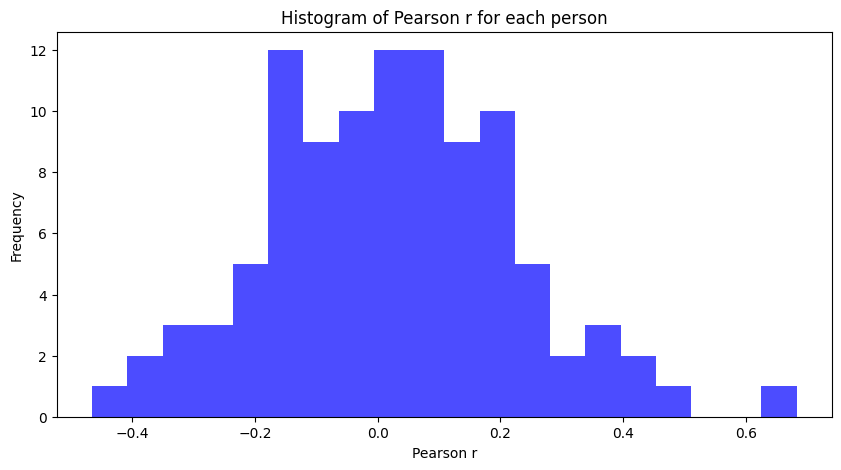

In [130]:
# Plot the histogram of pearson r
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist([x[1] for x in person_pearsonr], bins=20, color='b', alpha=0.7)
ax.set_xlabel("Pearson r")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Pearson r for each person")
plt.show()

In [131]:
person_pearsonr[:5], person_pearsonr[-5:]

([(17, -0.4652627661993015),
  (45, -0.3857403352506801),
  (4, -0.3621694715974627),
  (66, -0.34509298817113704),
  (95, -0.3080659742571614)],
 [(9, 0.38892201004973775),
  (58, 0.4100493480876336),
  (56, 0.4293485979598183),
  (99, 0.4683973447895149),
  (55, 0.6831620503130815)])

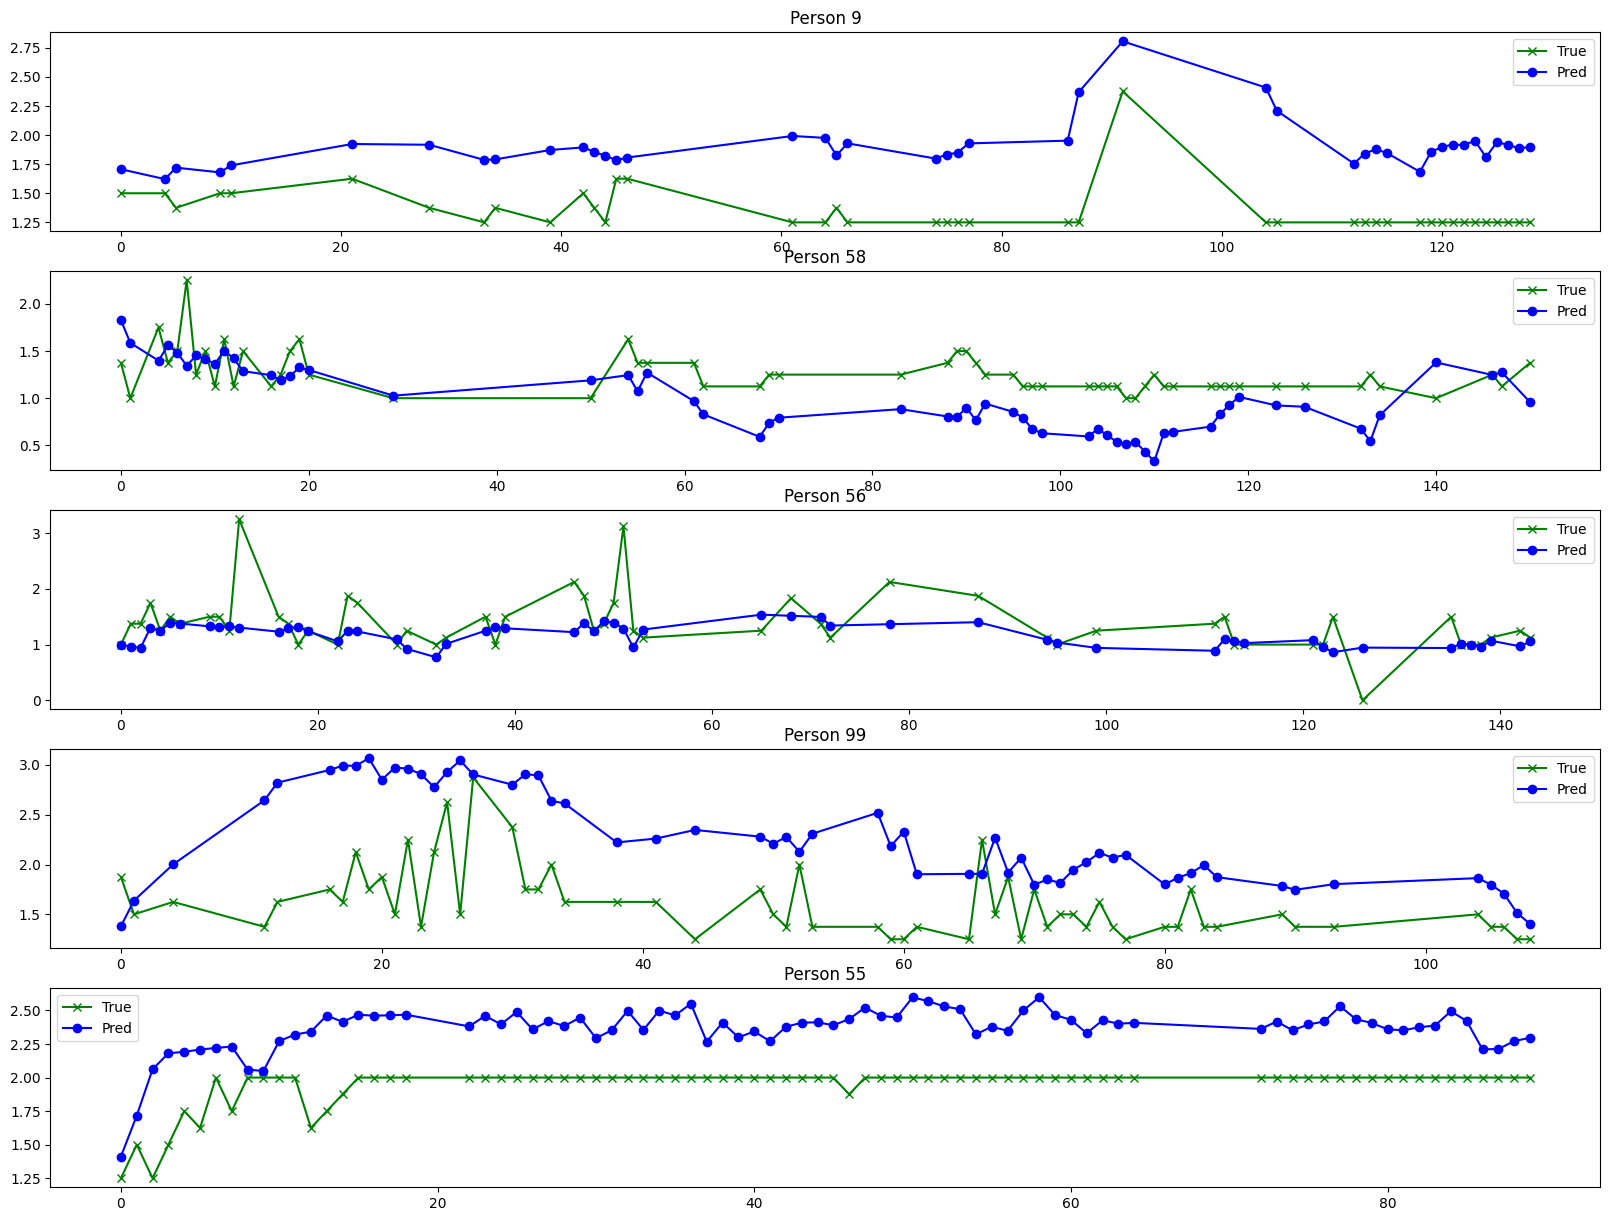

In [116]:
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Best 5
for idx, (person_idx, _) in enumerate(person_pearsonr[-5:]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    
plt.show()

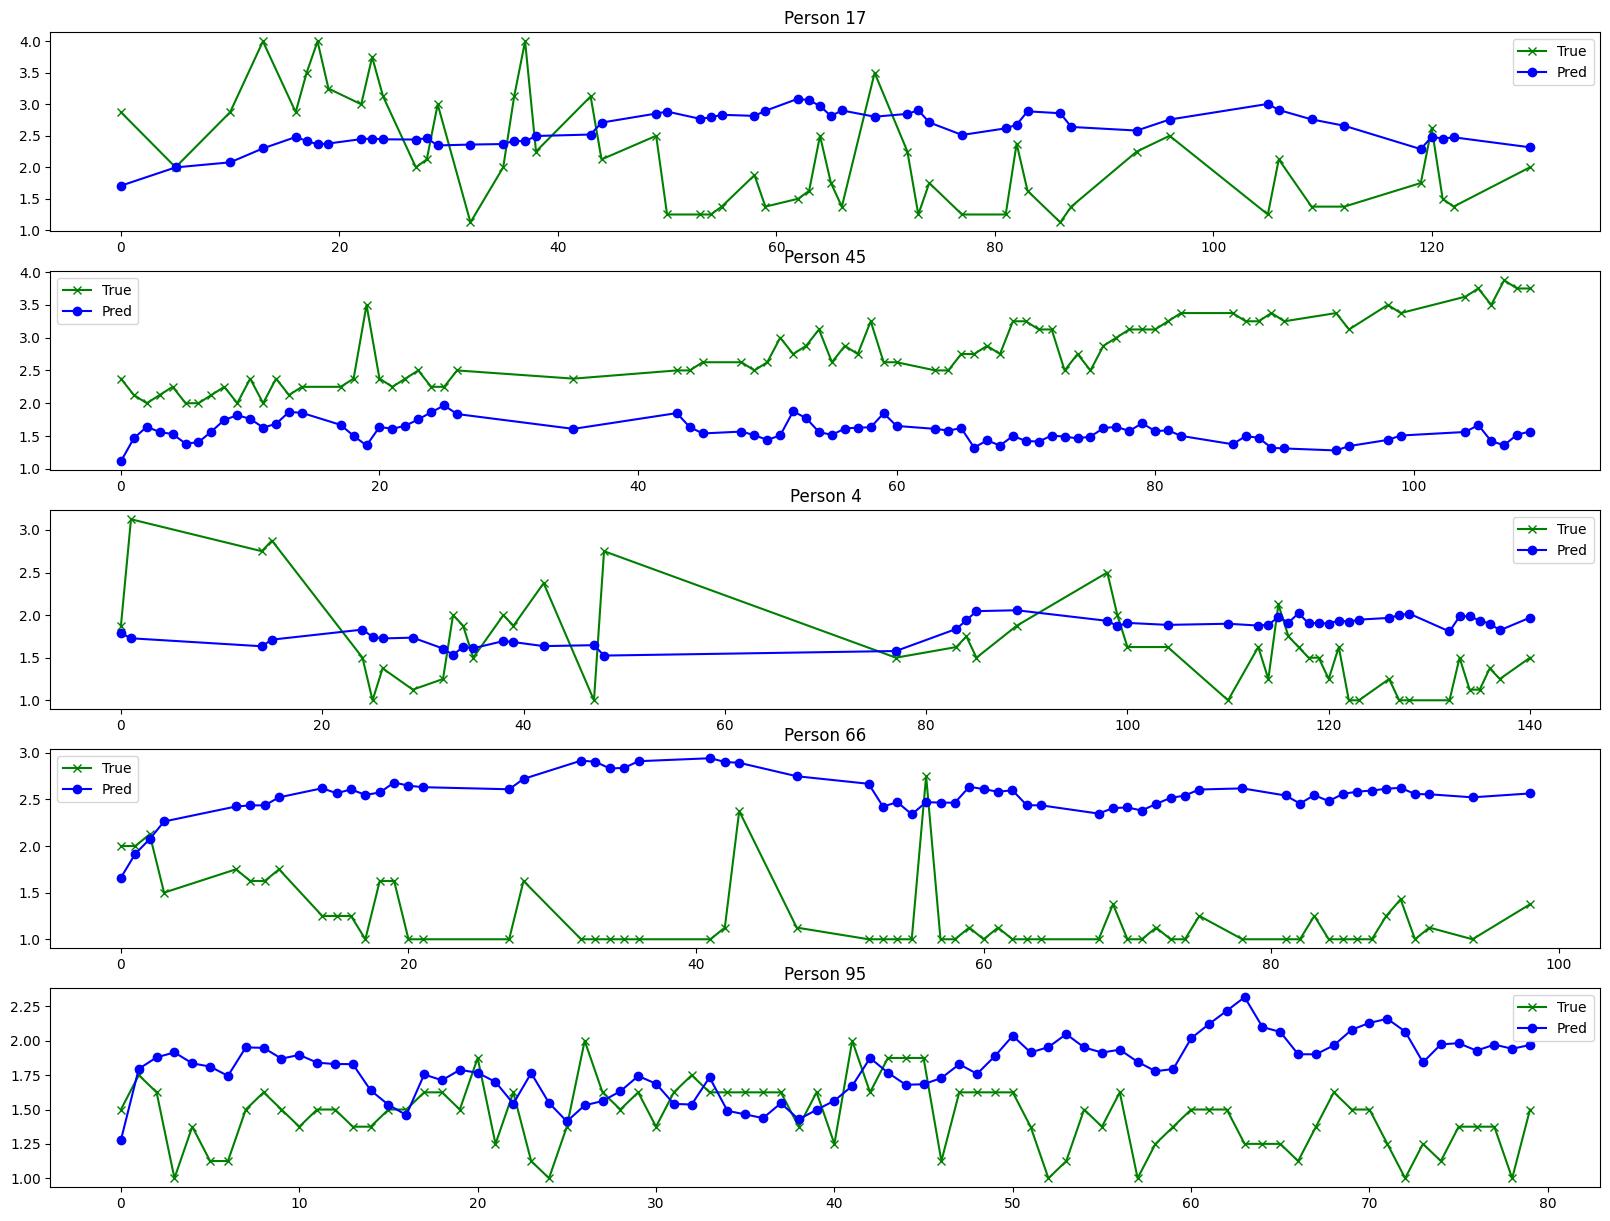

In [132]:
# Plot the y_true and y_pred in the same line plot and scatter plot. Use dayid in the x axis and y_true and y_pred in the y axis
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Worst 5
for idx, (person_idx, _) in enumerate(person_pearsonr[:5]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    
plt.show()

(0.027180364666969072, 0.8660420065393319)
(0.02802036458019898, 0.8051204597300615)
(0.029023478604344635, 0.8430753972044752)
(0.03487781164290535, 0.8308147511338365)
(0.03630833995210939, 0.7620465738286643)


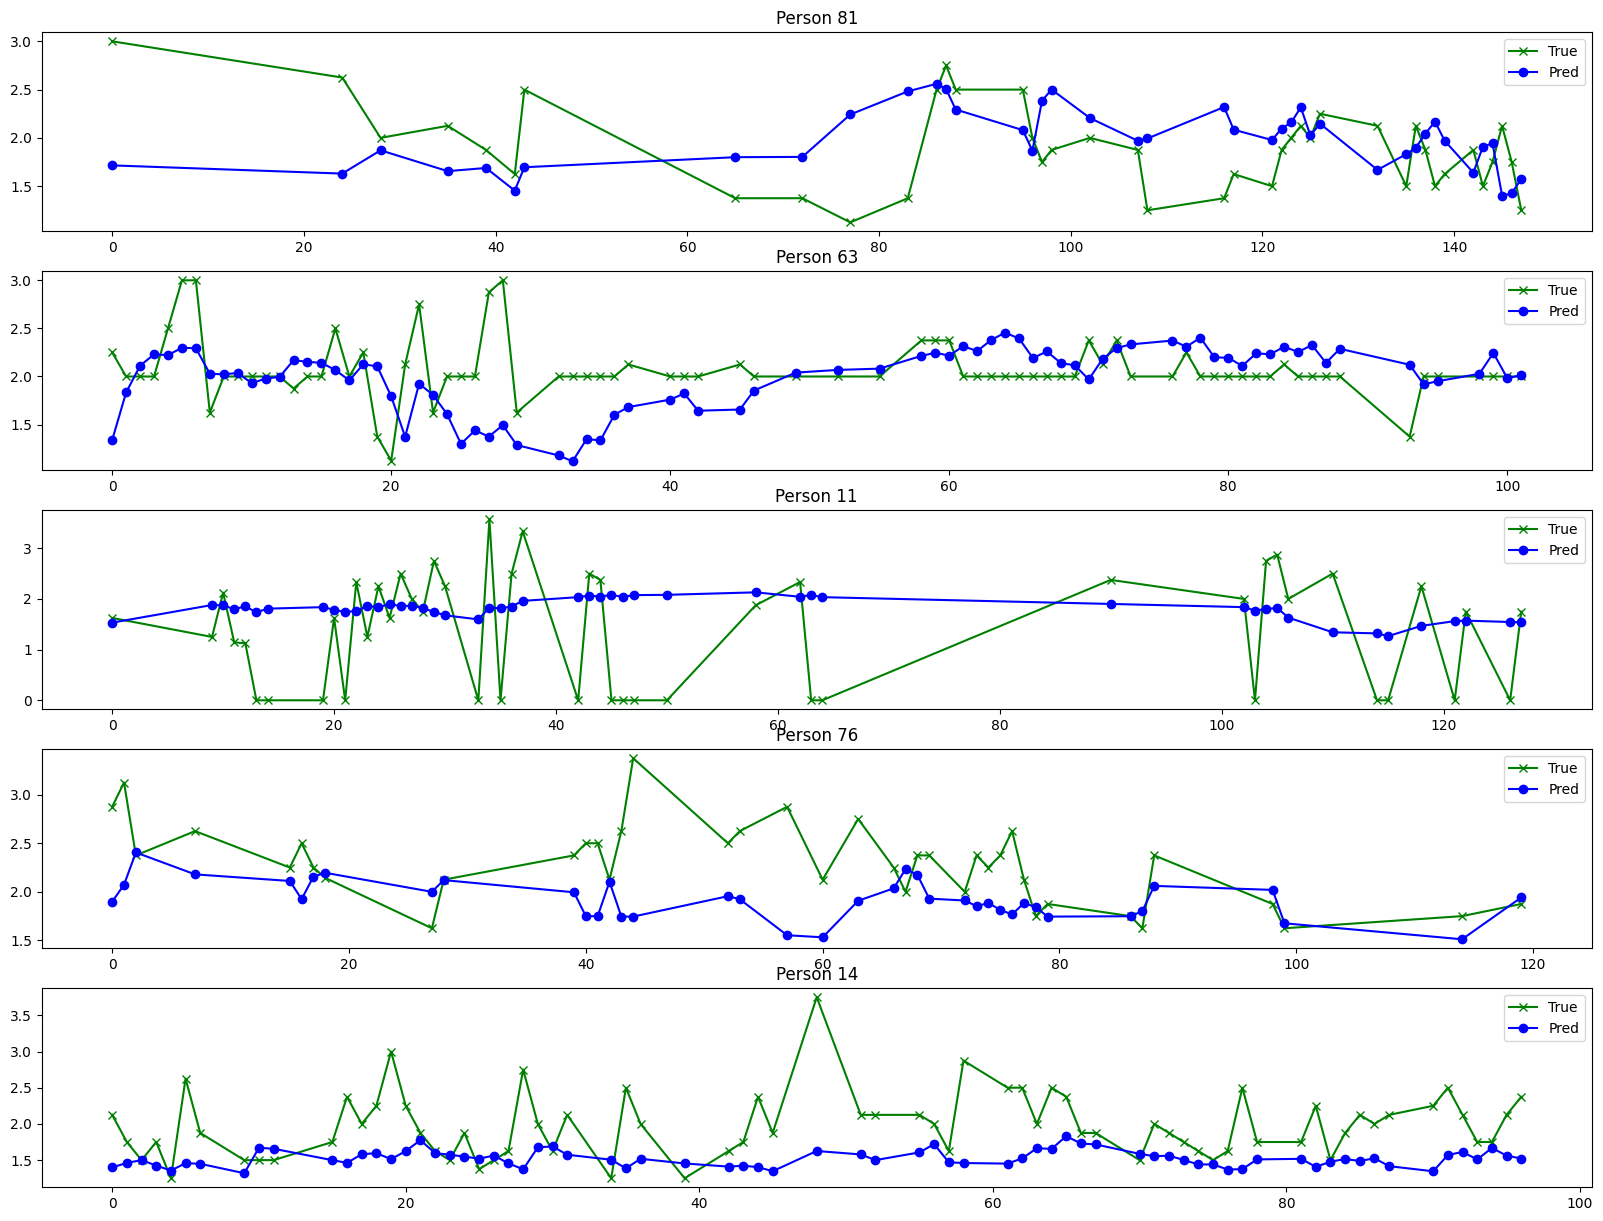

In [134]:
# Plot the y_true and y_pred in the same line plot and scatter plot. Use dayid in the x axis and y_true and y_pred in the y axis
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Middle 5
middle_idx = len(person_pearsonr)//2
for idx, (person_idx, _) in enumerate(person_pearsonr[middle_idx-2: middle_idx+3]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    print (pearsonr(all_folds_y_true[person_idx], all_folds_y_pred[person_idx]))
plt.show()

## 2 day ahead Predictions

In [146]:
all_folds_y_true = []
all_folds_y_pred = []
all_folds_y_dayid = []
for fold_num in range(5):
    preds_dict = pickle.load(open(PRED_PATHS_2d_ahead[f"fold{fold_num}"], "rb"))
    y_true, y_pred, y_dayid = get_ytrue_ypred(preds_dict)
    all_folds_y_true.extend(y_true)
    all_folds_y_pred.extend(y_pred)
    all_folds_y_dayid.extend(y_dayid)

flattened_pearsonr, person_pearsonr = calculate_pearsonr(all_folds_y_true, all_folds_y_pred)
print ("Flattened Pearsonr: {} (p={})".format(round(flattened_pearsonr[0], 3), round(flattened_pearsonr[1], 3)))
avg_person_pearsonr = np.mean([x[0] for x in person_pearsonr])
print ("Average Person Pearsonr: {}".format(round(avg_person_pearsonr, 3)))

Flattened Pearsonr: 0.422 (p=0.0)
Average Person Pearsonr: 0.046


In [147]:
get_stats(all_folds_y_dayid)

,count_people,count_instances,min_instances,max_instances,median_instances
0,102,6750,40,80,69.0


In [136]:
person_pearsonr = [(idx, x[0]) for idx, x in enumerate(person_pearsonr)]
person_pearsonr = sorted(person_pearsonr, key=lambda x: x[1])
person_pearsonr[:5], person_pearsonr[-5:]

([(31, -0.44138421957223883),
  (1, -0.4217064359067473),
  (46, -0.35421459146231365),
  (66, -0.35421459146231365),
  (17, -0.3480132896919624)],
 [(88, 0.4526093497889213),
  (100, 0.5539056996642998),
  (57, 0.5561141085943638),
  (77, 0.5561141085943638),
  (84, 0.6046894785024826)])

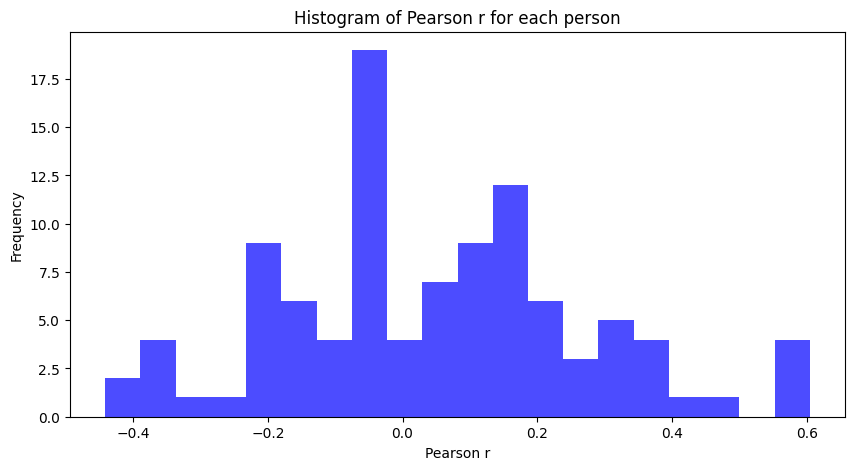

In [137]:
# Plot the histogram of pearson r
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist([x[1] for x in person_pearsonr], bins=20, color='b', alpha=0.7)
ax.set_xlabel("Pearson r")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Pearson r for each person")
plt.show()

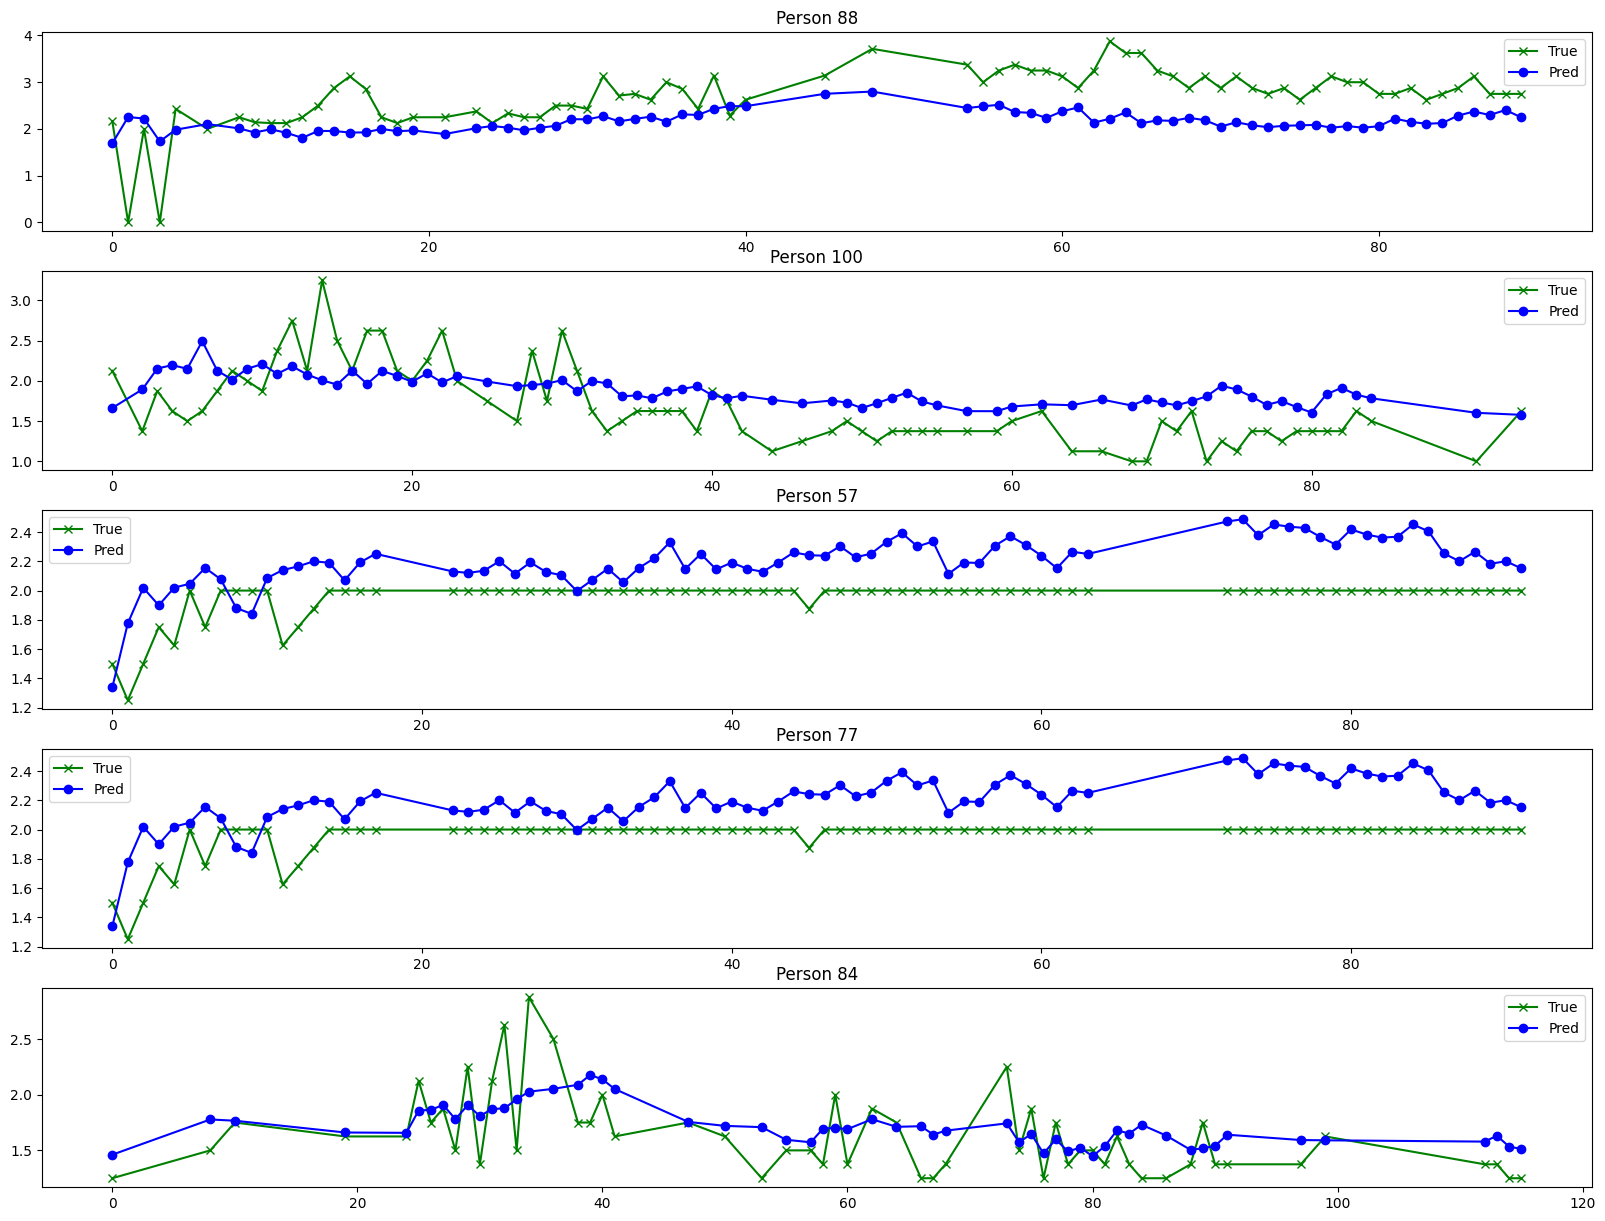

In [138]:
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Best 5
for idx, (person_idx, _) in enumerate(person_pearsonr[-5:]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    
plt.show()

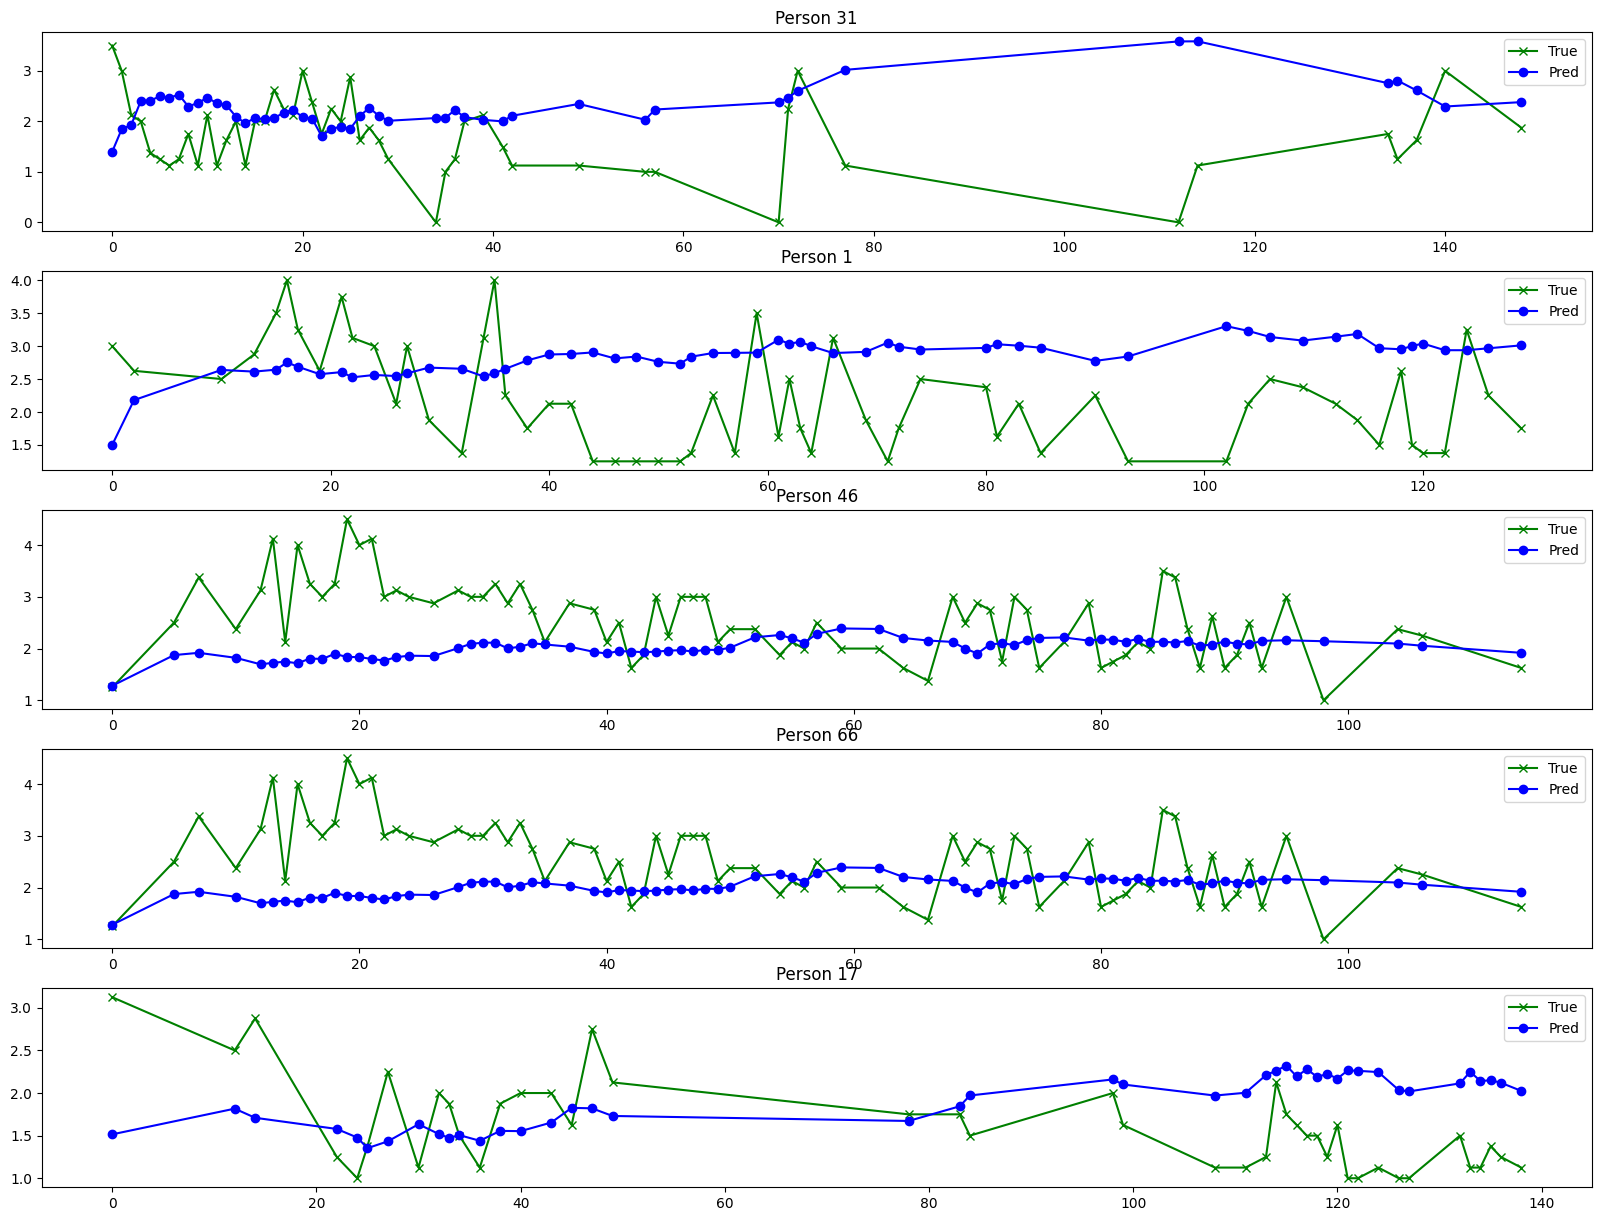

In [139]:
# Plot the y_true and y_pred in the same line plot and scatter plot. Use dayid in the x axis and y_true and y_pred in the y axis
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Bottom 5
for idx, (person_idx, _) in enumerate(person_pearsonr[:5]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    
plt.show()

(0.017090338402472073, 0.8959905603427117)
(0.03597780857673665, 0.764149620332853)
(0.04133899869857715, 0.7538182918544458)
(0.04133899869857715, 0.7538182918544458)
(0.0441848049519614, 0.7124714305190588)


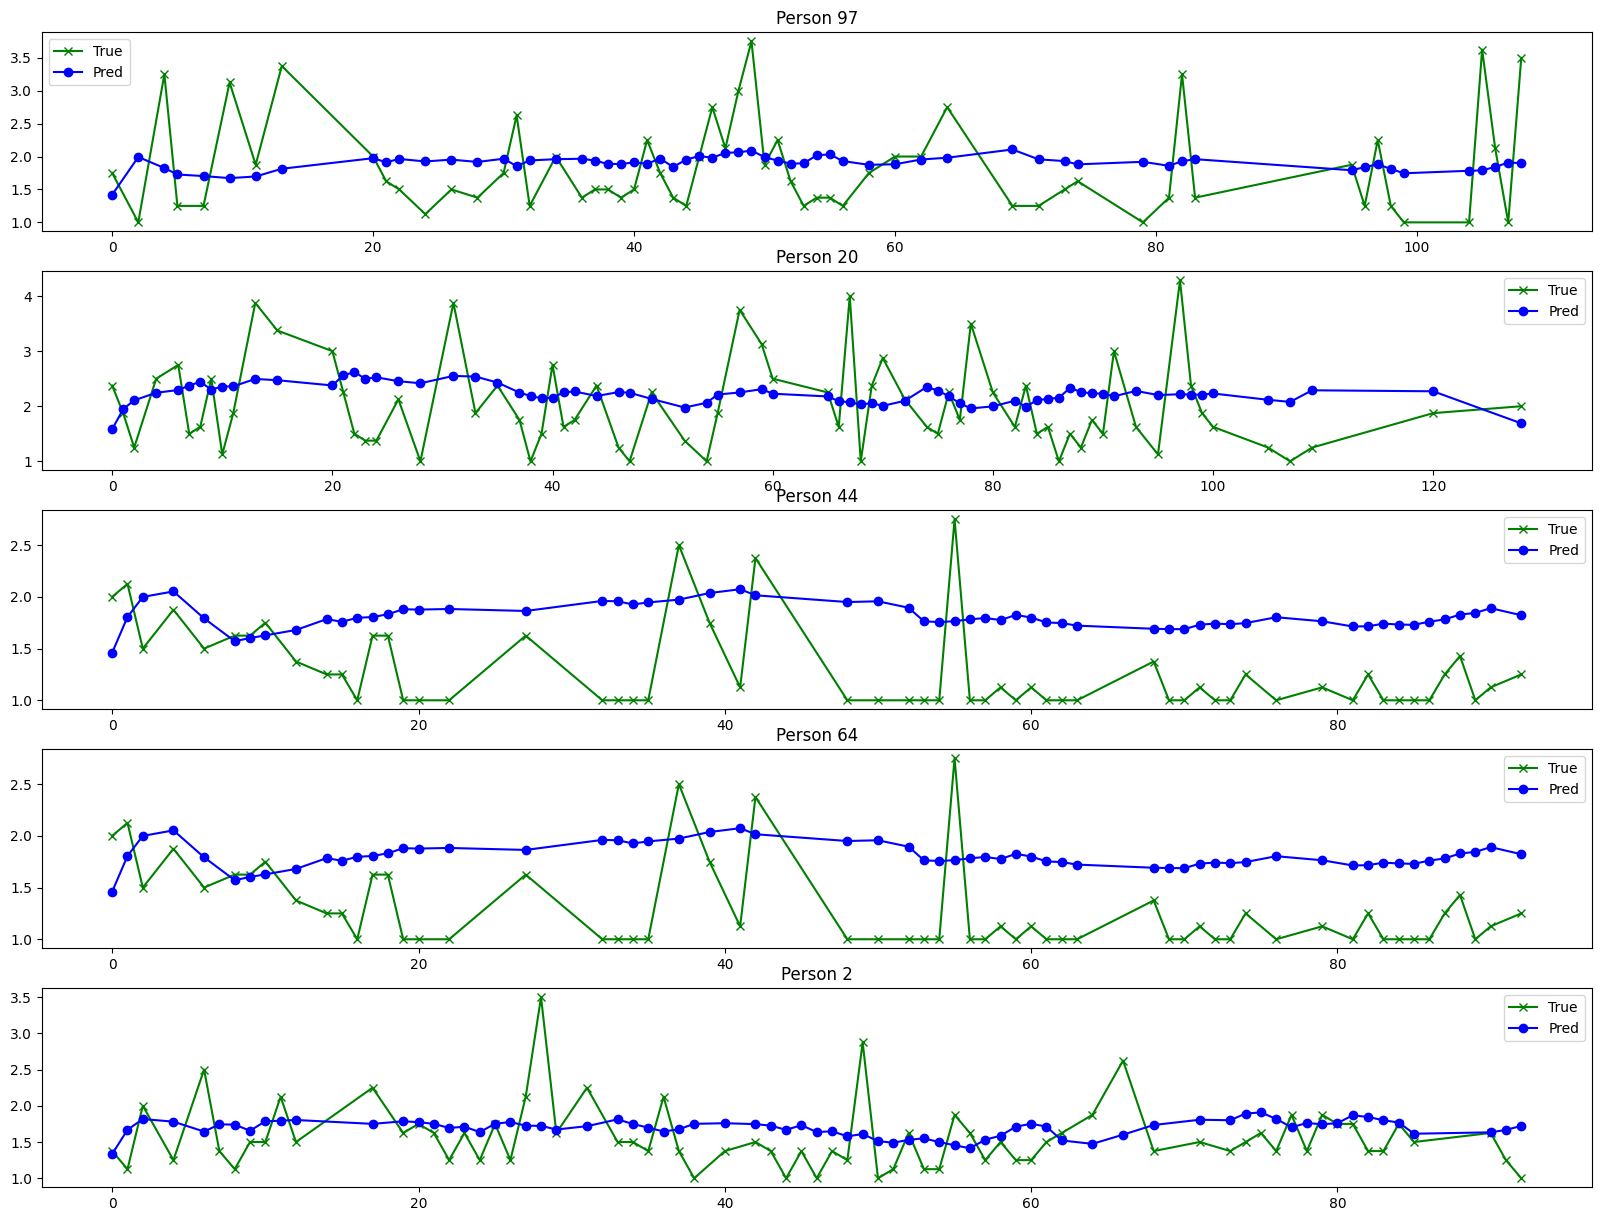

In [140]:
# Plot the y_true and y_pred in the same line plot and scatter plot. Use dayid in the x axis and y_true and y_pred in the y axis
fig, ax = plt.subplots(5, 1, figsize=(20, 15)) # Middle 5
middle_idx = len(person_pearsonr)//2
for idx, (person_idx, _) in enumerate(person_pearsonr[middle_idx-2: middle_idx+3]):
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_true[person_idx], label="True", color='green', marker='x')
    ax[idx].plot(all_folds_y_dayid[person_idx], all_folds_y_pred[person_idx], label="Pred", color='blue', marker='o')
    ax[idx].set_title(f"Person {person_idx}")
    ax[idx].legend()
    print (pearsonr(all_folds_y_true[person_idx], all_folds_y_pred[person_idx]))
plt.show()